In [1]:
from quantum_dataset import QM7, QM7b, QM9, Champs, SuperSet
from quantum_learning import Learn, Selector, ChampSelector
from quantum_model import FFNet
from torch.optim import Adam
from torch.nn import MSELoss, L1Loss

RDKit WARNING: [18:00:35] Enabling RDKit 2019.09.3 jupyter extensions


loading QM9 datadic from a pickled copy...
<class 'quantum_dataset.SuperSet'> dataset created...
test loss: 3.4477086898888616
y_pred:
tensor([[ 1.4397],
        [ 1.3586],
        [ 2.1554],
        [80.3490],
        [ 2.3704],
        [-2.8867],
        [ 0.5676],
        [ 2.2706],
        [ 7.8015],
        [-2.2384]], device='cuda:0')
 y:
tensor([[-0.8672],
        [ 5.0133],
        [ 6.1120],
        [86.1857],
        [ 4.5326],
        [ 1.4296],
        [ 1.4466],
        [ 1.5831],
        [ 7.7080],
        [-7.5991]], device='cuda:0')


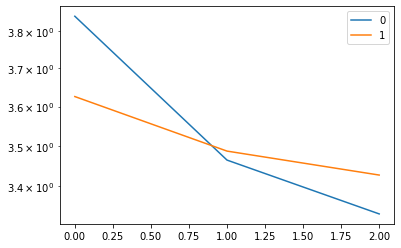

learning time: 3:55:42.930075


In [2]:
opt_params = {'lr': 0.001}
model_params = {'D_in': 29*29+29+15+128+32+64+32+64, 'H': 8192, 'D_out': 1, 'model_name': 'funnel'}
qm9_params = {'n': 133885, 
              'features': ['coulomb','mulliken','A','B','C','mu','alpha','homo',
                           'lumo','gap','r2','zpve','U0','U','H','G','Cv'],  
              'dim': 29, 
              'use_pickle': True}
champs_params = {'n': 4658146, 
                 'features': False,
                 'use_h5': False,  
                 'infer': False}
crit_params = {'reduction': 'sum'}
ds_params = {'PrimaryDS': Champs, 'SecondaryDS': QM9, 'p_params': champs_params, 's_params': qm9_params}
sample_params = {'split': .1, 'subset': False}

Learn(Dataset=SuperSet, Model=FFNet, Sampler=ChampSelector, Optimizer=Adam, Criterion=L1Loss,
      batch_size=32, epochs=3, model_params=model_params, ds_params=ds_params, 
      sample_params=sample_params, opt_params=opt_params, crit_params=crit_params, 
      save_model=True, load_model=False)

In [7]:
model_params = {'D_in': 29*29+29+15+128+32+64+32+64, 
                'H': 8192, 
                'D_out': 1, 
                'model_name': 'funnel'}
ds_params = {'n': 2505542, 
             'features': False,
             'use_h5': False,  
             'infer': True}

Learn(Dataset=Champs, Model=FFNet, Sampler=Selector, batch_size=32, model_params=model_params, 
      ds_params=ds_params, load_model='./models/20200629_1800.pth', adapt=False)

<class 'quantum_dataset.Champs'> dataset created...
model loaded from state_dict...


RuntimeError: running_mean should contain 320 elements not 1205

In [ ]:
#create an inference baseline result using the mean training values for each type of scc
df = pd.read_csv('./data/champs/'+'train.csv', header=0, names=['id','molecule_name', 
                 'atom_index_0','atom_index_1','type','scalar_coupling_constant'], index_col=False)
dt = df.groupby('type')['scalar_coupling_constant'].describe()
test = pd.read_csv('./data/champs/'+'test.csv', header=0, names=['id','molecule_name', 
                   'atom_index_0','atom_index_1','type'], index_col=False)
test['scalar_coupling_constant'] = [dt['mean'].loc[x] for x in test['type']]
test[['id','scalar_coupling_constant']].to_csv('mean_inference.csv', 
                                               header=['id','scalar_coupling_constant'], 
                                               index=False)